In [1]:
import os
os.listdir('/kaggle/input/mura-dataset/dataset')

['valid', 'train']

Epoch 1/5, Train Loss: 1.2813, Train Accuracy: 0.5239, Valid Accuracy: 0.7074
Saved best model with validation accuracy: 0.7074 at ./models/best_custom_cnn.pth
Epoch 2/5, Train Loss: 0.7738, Train Accuracy: 0.7318, Valid Accuracy: 0.8189
Saved best model with validation accuracy: 0.8189 at ./models/best_custom_cnn.pth
Epoch 3/5, Train Loss: 0.5637, Train Accuracy: 0.8072, Valid Accuracy: 0.8377
Saved best model with validation accuracy: 0.8377 at ./models/best_custom_cnn.pth
Epoch 4/5, Train Loss: 0.4337, Train Accuracy: 0.8520, Valid Accuracy: 0.8731
Saved best model with validation accuracy: 0.8731 at ./models/best_custom_cnn.pth
Epoch 5/5, Train Loss: 0.3362, Train Accuracy: 0.8890, Valid Accuracy: 0.8800
Saved best model with validation accuracy: 0.8800 at ./models/best_custom_cnn.pth
Saved final model at ./models/final_custom_cnn.pth


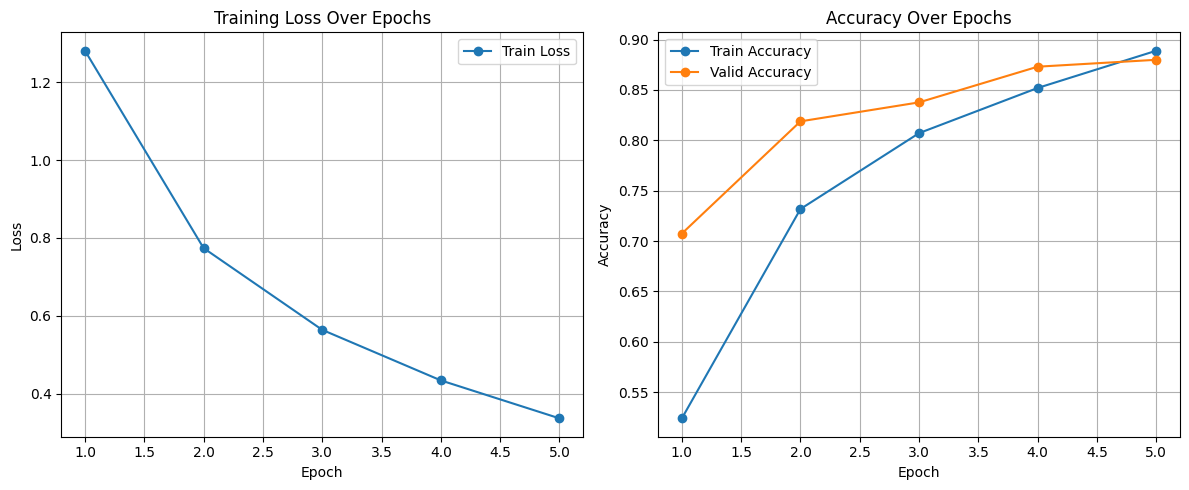

Classification Report:
              precision    recall  f1-score   support

    XR_ELBOW       0.91      0.79      0.84       250
   XR_FINGER       0.87      0.92      0.89       250
  XR_FOREARM       0.81      0.86      0.83       250
     XR_HAND       0.91      0.89      0.90       250
  XR_HUMERUS       0.83      0.94      0.88       250
 XR_SHOULDER       0.95      0.86      0.91       250
    XR_WRIST       0.90      0.89      0.90       250

    accuracy                           0.88      1750
   macro avg       0.88      0.88      0.88      1750
weighted avg       0.88      0.88      0.88      1750



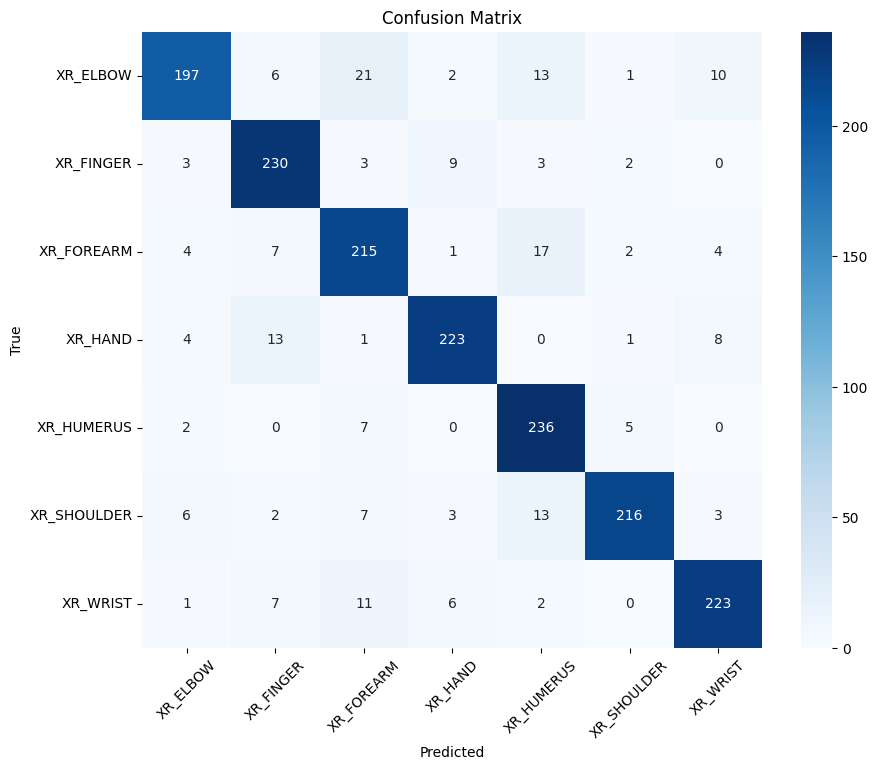


Final Metrics:
{'accuracy': 0.88, 'precision': {'XR_ELBOW': 0.9078341013824884, 'XR_FINGER': 0.8679245283018868, 'XR_FOREARM': 0.8113207547169812, 'XR_HAND': 0.9139344262295082, 'XR_HUMERUS': 0.8309859154929577, 'XR_SHOULDER': 0.9515418502202643, 'XR_WRIST': 0.8991935483870968}, 'recall': {'XR_ELBOW': 0.788, 'XR_FINGER': 0.92, 'XR_FOREARM': 0.86, 'XR_HAND': 0.892, 'XR_HUMERUS': 0.944, 'XR_SHOULDER': 0.864, 'XR_WRIST': 0.892}, 'f1-score': {'XR_ELBOW': 0.8436830835117773, 'XR_FINGER': 0.8932038834951457, 'XR_FOREARM': 0.8349514563106797, 'XR_HAND': 0.9028340080971659, 'XR_HUMERUS': 0.8838951310861424, 'XR_SHOULDER': 0.9056603773584905, 'XR_WRIST': 0.895582329317269}}


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the 7 classes (body parts)
classes = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Function to collect image paths and labels
def get_data_list(data_dir, split='train'):
    data_list = []
    for body_part in classes:
        dir_path = os.path.join(data_dir, split, body_part)
        if os.path.exists(dir_path):
            for file in os.listdir(dir_path):
                if file.endswith('.png'):
                    image_path = os.path.join(dir_path, file)
                    label = class_to_idx[body_part]
                    data_list.append((image_path, label))
    return data_list

# Define dataset class
class MURADataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path, label = self.data_list[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data lists for train and valid
data_dir = '/kaggle/input/mura-dataset/dataset'
train_data_list = get_data_list(data_dir, split='train')
valid_data_list = get_data_list(data_dir, split='valid')

# Create datasets and dataloaders
train_dataset = MURADataset(train_data_list, transform=transform)
valid_dataset = MURADataset(valid_data_list, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Define a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            # Conv Layer 1: 3 input channels (RGB), 32 filters, 3x3 kernel
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 112x112x32

            # Conv Layer 2: 32 input channels, 64 filters, 3x3 kernel
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 56x56x64

            # Conv Layer 3: 64 input channels, 128 filters, 3x3 kernel
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 28x28x128

            # Conv Layer 4: 128 input channels, 256 filters, 3x3 kernel
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 14x14x256
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),  # 14x14 feature map size after pooling
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the custom CNN
model = CustomCNN(num_classes=len(classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training function with accuracy tracking
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluation function (validation accuracy)
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
valid_accuracies = []

# Define paths for saving models
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, 'best_custom_cnn.pth')
final_model_path = os.path.join(model_dir, 'final_custom_cnn.pth')

# Train for a few epochs and track metrics
num_epochs = 5
best_valid_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    valid_acc = evaluate(model, valid_loader, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Valid Accuracy: {valid_acc:.4f}')
    
    # Save the model if it has the best validation accuracy so far
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with validation accuracy: {best_valid_acc:.4f} at {best_model_path}')

# Save the final model after training
torch.save(model.state_dict(), final_model_path)
print(f'Saved final model at {final_model_path}')

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compute all metrics with detailed report and confusion matrix
def compute_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    report = classification_report(all_labels, all_preds, target_names=classes)
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
    report_dict = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
    return {
        'accuracy': report_dict['accuracy'],
        'precision': {cls: report_dict[cls]['precision'] for cls in classes},
        'recall': {cls: report_dict[cls]['recall'] for cls in classes},
        'f1-score': {cls: report_dict[cls]['f1-score'] for cls in classes}
    }

# Compute and display metrics
metrics = compute_metrics(model, valid_loader, device)
print("\nFinal Metrics:")
print(metrics)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 227MB/s]


Epoch 1/5, Train Loss: 0.2336, Train Accuracy: 0.9327, Valid Accuracy: 0.9789
Saved best model with validation accuracy: 0.9789 at ./models/best_mobilenet_v2.pth
Epoch 2/5, Train Loss: 0.0715, Train Accuracy: 0.9796, Valid Accuracy: 0.9834
Saved best model with validation accuracy: 0.9834 at ./models/best_mobilenet_v2.pth
Epoch 3/5, Train Loss: 0.0421, Train Accuracy: 0.9879, Valid Accuracy: 0.9806
Epoch 4/5, Train Loss: 0.0268, Train Accuracy: 0.9921, Valid Accuracy: 0.9874
Saved best model with validation accuracy: 0.9874 at ./models/best_mobilenet_v2.pth
Epoch 5/5, Train Loss: 0.0160, Train Accuracy: 0.9950, Valid Accuracy: 0.9766
Saved final model at ./models/final_mobilenet_v2.pth


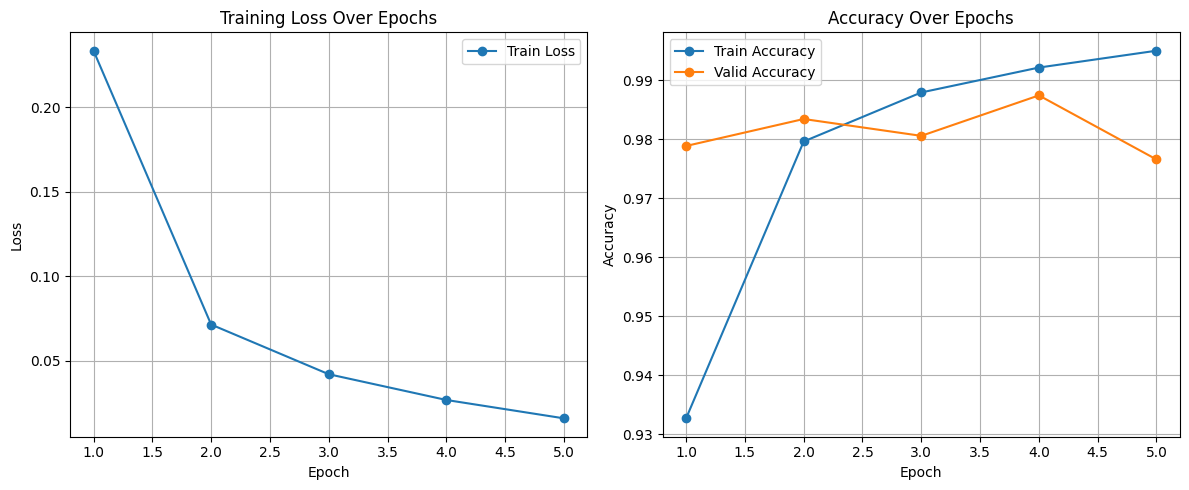

Classification Report:
              precision    recall  f1-score   support

    XR_ELBOW       1.00      0.94      0.97       250
   XR_FINGER       0.98      0.97      0.98       250
  XR_FOREARM       0.95      0.98      0.96       250
     XR_HAND       0.96      0.98      0.97       250
  XR_HUMERUS       0.98      0.99      0.98       250
 XR_SHOULDER       0.99      0.98      0.99       250
    XR_WRIST       0.99      0.99      0.99       250

    accuracy                           0.98      1750
   macro avg       0.98      0.98      0.98      1750
weighted avg       0.98      0.98      0.98      1750



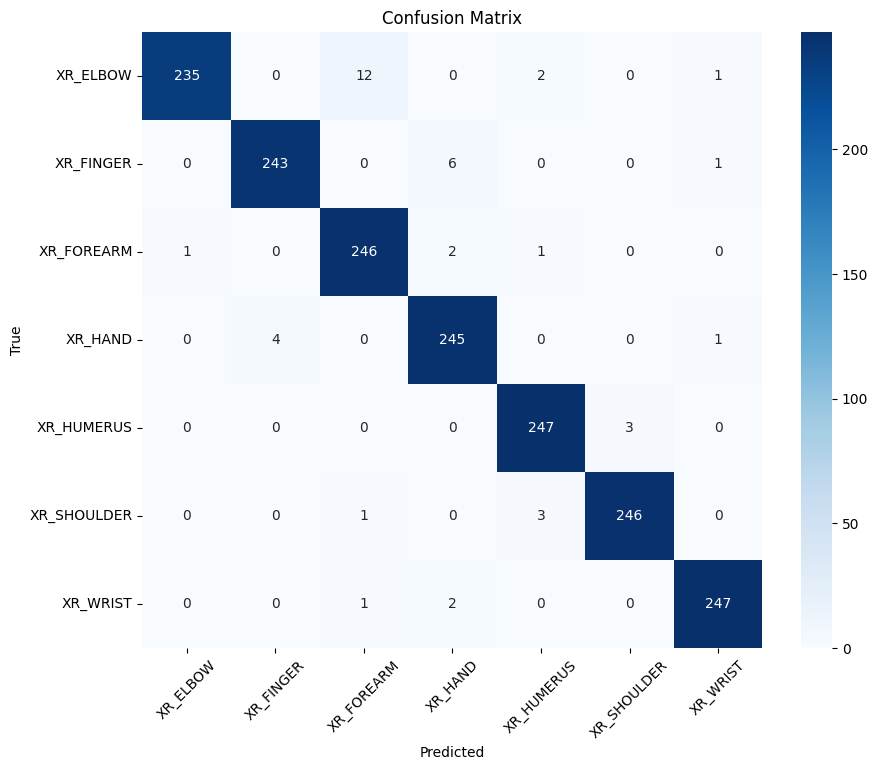


Final Metrics:
{'accuracy': 0.9765714285714285, 'precision': {'XR_ELBOW': 0.9957627118644068, 'XR_FINGER': 0.9838056680161943, 'XR_FOREARM': 0.9461538461538461, 'XR_HAND': 0.9607843137254902, 'XR_HUMERUS': 0.9762845849802372, 'XR_SHOULDER': 0.9879518072289156, 'XR_WRIST': 0.988}, 'recall': {'XR_ELBOW': 0.94, 'XR_FINGER': 0.972, 'XR_FOREARM': 0.984, 'XR_HAND': 0.98, 'XR_HUMERUS': 0.988, 'XR_SHOULDER': 0.984, 'XR_WRIST': 0.988}, 'f1-score': {'XR_ELBOW': 0.9670781893004115, 'XR_FINGER': 0.977867203219316, 'XR_FOREARM': 0.9647058823529412, 'XR_HAND': 0.9702970297029702, 'XR_HUMERUS': 0.9821073558648111, 'XR_SHOULDER': 0.9859719438877755, 'XR_WRIST': 0.988}}


In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the 7 classes (body parts)
classes = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Function to collect image paths and labels
def get_data_list(data_dir, split='train'):
    data_list = []
    for body_part in classes:
        dir_path = os.path.join(data_dir, split, body_part)
        if os.path.exists(dir_path):
            for file in os.listdir(dir_path):
                if file.endswith('.png'):
                    image_path = os.path.join(dir_path, file)
                    label = class_to_idx[body_part]
                    data_list.append((image_path, label))
    return data_list

# Define dataset class
class MURADataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path, label = self.data_list[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data lists for train and valid
data_dir = '/kaggle/input/mura-dataset/dataset'
train_data_list = get_data_list(data_dir, split='train')
valid_data_list = get_data_list(data_dir, split='valid')

# Create datasets and dataloaders
train_dataset = MURADataset(train_data_list, transform=transform)
valid_dataset = MURADataset(valid_data_list, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Load pre-trained MobileNetV2 and modify for 7 classes
model = models.mobilenet_v2(pretrained=True)
# Modify the classifier layer (MobileNetV2 uses a different structure than ResNet)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training function with accuracy tracking
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluation function (validation accuracy)
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
valid_accuracies = []

# Define paths for saving models
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, 'best_mobilenet_v2.pth')
final_model_path = os.path.join(model_dir, 'final_mobilenet_v2.pth')

# Train for a few epochs and track metrics
num_epochs = 5
best_valid_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    valid_acc = evaluate(model, valid_loader, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Valid Accuracy: {valid_acc:.4f}')
    
    # Save the model if it has the best validation accuracy so far
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with validation accuracy: {best_valid_acc:.4f} at {best_model_path}')

# Save the final model after training
torch.save(model.state_dict(), final_model_path)
print(f'Saved final model at {final_model_path}')

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compute all metrics with detailed report and confusion matrix
def compute_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    report = classification_report(all_labels, all_preds, target_names=classes)
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
    report_dict = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
    return {
        'accuracy': report_dict['accuracy'],
        'precision': {cls: report_dict[cls]['precision'] for cls in classes},
        'recall': {cls: report_dict[cls]['recall'] for cls in classes},
        'f1-score': {cls: report_dict[cls]['f1-score'] for cls in classes}
    }

# Compute and display metrics
metrics = compute_metrics(model, valid_loader, device)
print("\nFinal Metrics:")
print(metrics)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features for training set...
Extracting features for validation set...
SVM training completed.
Saved ResNet feature extractor at ./models/resnet50_feature_extractor.pth
Saved SVM classifier at ./models/svm_classifier.pkl
Train Accuracy: 1.0000, Valid Accuracy: 0.9549


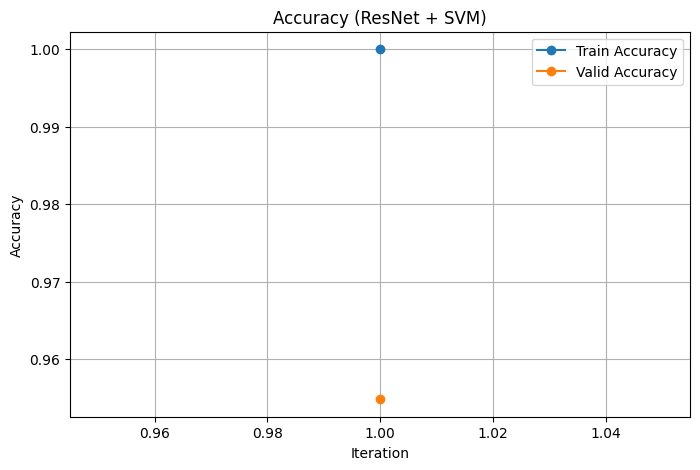


Validation Metrics:
Classification Report:
              precision    recall  f1-score   support

    XR_ELBOW       0.93      0.92      0.93       250
   XR_FINGER       0.96      0.97      0.96       250
  XR_FOREARM       0.93      0.94      0.94       250
     XR_HAND       0.98      0.95      0.96       250
  XR_HUMERUS       0.95      0.98      0.96       250
 XR_SHOULDER       0.99      0.98      0.98       250
    XR_WRIST       0.96      0.94      0.95       250

    accuracy                           0.95      1750
   macro avg       0.96      0.95      0.95      1750
weighted avg       0.96      0.95      0.95      1750



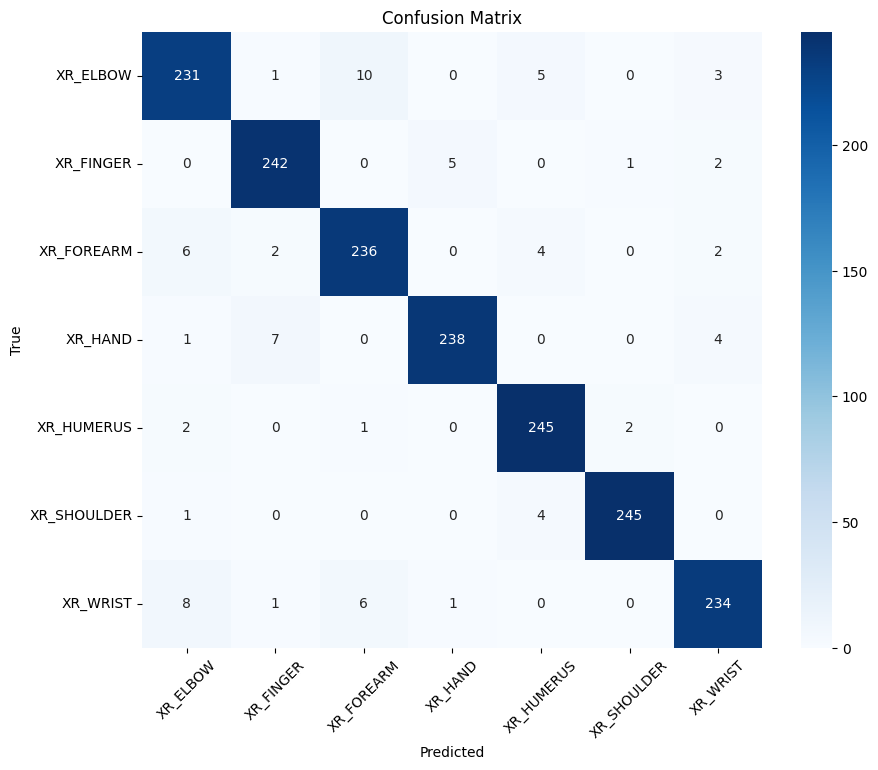


Final Metrics:
{'accuracy': 0.9548571428571428, 'precision': {'XR_ELBOW': 0.927710843373494, 'XR_FINGER': 0.9565217391304348, 'XR_FOREARM': 0.932806324110672, 'XR_HAND': 0.9754098360655737, 'XR_HUMERUS': 0.9496124031007752, 'XR_SHOULDER': 0.9879032258064516, 'XR_WRIST': 0.9551020408163265}, 'recall': {'XR_ELBOW': 0.924, 'XR_FINGER': 0.968, 'XR_FOREARM': 0.944, 'XR_HAND': 0.952, 'XR_HUMERUS': 0.98, 'XR_SHOULDER': 0.98, 'XR_WRIST': 0.936}, 'f1-score': {'XR_ELBOW': 0.9258517034068137, 'XR_FINGER': 0.9622266401590457, 'XR_FOREARM': 0.9383697813121272, 'XR_HAND': 0.9635627530364372, 'XR_HUMERUS': 0.9645669291338583, 'XR_SHOULDER': 0.9839357429718876, 'XR_WRIST': 0.9454545454545455}}


In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Define the 7 classes (body parts)
classes = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Function to collect image paths and labels
def get_data_list(data_dir, split='train'):
    data_list = []
    for body_part in classes:
        dir_path = os.path.join(data_dir, split, body_part)
        if os.path.exists(dir_path):
            for file in os.listdir(dir_path):
                if file.endswith('.png'):
                    image_path = os.path.join(dir_path, file)
                    label = class_to_idx[body_part]
                    data_list.append((image_path, label))
    return data_list

# Define dataset class
class MURADataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path, label = self.data_list[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data lists for train and valid
data_dir = '/kaggle/input/mura-dataset/dataset'
train_data_list = get_data_list(data_dir, split='train')
valid_data_list = get_data_list(data_dir, split='valid')

# Create datasets and dataloaders
train_dataset = MURADataset(train_data_list, transform=transform)
valid_dataset = MURADataset(valid_data_list, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffle for feature extraction
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet50 and modify to extract features
model = models.resnet50(pretrained=True)
# Remove the final fully connected layer to get features (2048-dimensional)
model = nn.Sequential(*list(model.children())[:-1])  # Everything except the last fc layer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # Set to evaluation mode for feature extraction

# Function to extract features from the dataset
def extract_features(model, data_loader, device):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            outputs = model(images)  # Shape: [batch_size, 2048, 1, 1]
            outputs = outputs.view(outputs.size(0), -1)  # Flatten to [batch_size, 2048]
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features for training and validation sets
print("Extracting features for training set...")
train_features, train_labels = extract_features(model, train_loader, device)
print("Extracting features for validation set...")
valid_features, valid_labels = extract_features(model, valid_loader, device)

# Train SVM classifier
svm = SVC(kernel='linear', C=1.0, probability=True)  # Linear kernel, enable probability for metrics
svm.fit(train_features, train_labels)
print("SVM training completed.")

# Define paths for saving models
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)
resnet_path = os.path.join(model_dir, 'resnet50_feature_extractor.pth')
svm_path = os.path.join(model_dir, 'svm_classifier.pkl')

# Save ResNet feature extractor
torch.save(model.state_dict(), resnet_path)
print(f'Saved ResNet feature extractor at {resnet_path}')

# Save SVM model
with open(svm_path, 'wb') as f:
    pickle.dump(svm, f)
print(f'Saved SVM classifier at {svm_path}')

# Simulate epochs for plotting (since SVM doesn't train in epochs, we'll use one "epoch" for simplicity)
train_accuracies = []
valid_accuracies = []
train_losses = []  # Dummy loss since SVM doesn't use loss like neural nets

# Evaluate SVM on training and validation sets
train_preds = svm.predict(train_features)
valid_preds = svm.predict(valid_features)

train_acc = np.mean(train_preds == train_labels)
valid_acc = np.mean(valid_preds == valid_labels)

# Append metrics (single "epoch" for SVM)
train_accuracies.append(train_acc)
valid_accuracies.append(valid_acc)
train_losses.append(0)  # Placeholder since SVM doesn't provide a loss directly

print(f'Train Accuracy: {train_acc:.4f}, Valid Accuracy: {valid_acc:.4f}')

# Plot Accuracy (no loss plot since SVM doesn't provide loss)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 2), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, 2), valid_accuracies, label='Valid Accuracy', marker='o')
plt.title('Accuracy (ResNet + SVM)')
plt.xlabel('Iteration')  # Only one iteration since SVM is not epoch-based
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Compute all metrics with detailed report and confusion matrix
def compute_metrics(svm, features, true_labels):
    preds = svm.predict(features)
    print("Classification Report:")
    report = classification_report(true_labels, preds, target_names=classes)
    print(report)
    
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
    report_dict = classification_report(true_labels, preds, target_names=classes, output_dict=True)
    return {
        'accuracy': report_dict['accuracy'],
        'precision': {cls: report_dict[cls]['precision'] for cls in classes},
        'recall': {cls: report_dict[cls]['recall'] for cls in classes},
        'f1-score': {cls: report_dict[cls]['f1-score'] for cls in classes}
    }

# Compute and display metrics for validation set
print("\nValidation Metrics:")
metrics = compute_metrics(svm, valid_features, valid_labels)
print("\nFinal Metrics:")
print(metrics)

In [6]:
# Load ResNet feature extractor
model = models.resnet50(pretrained=False)
model = nn.Sequential(*list(model.children())[:-1])
model.load_state_dict(torch.load('./models/resnet50_feature_extractor.pth'))
model = model.to(device)
model.eval()

# Load SVM classifier
with open('./models/svm_classifier.pkl', 'rb') as f:
    svm = pickle.load(f)

# Example inference on a new image
image = Image.open('/kaggle/input/mura-dataset/dataset/train/XR_ELBOW/1006.png').convert('RGB')
image = transform(image).unsqueeze(0).to(device)
with torch.no_grad():
    features = model(image).view(1, -1).cpu().numpy()
prediction = svm.predict(features)[0]
print(f'Predicted class: {classes[prediction]}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-6-f001d0c6db40>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

Predicted class: XR_ELBOW


In [7]:
import torch
from torchvision import models, transforms
from PIL import Image
import os

# Define the 7 classes (body parts)
classes = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']

# Define the same transforms used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to the saved MobileNetV2 model
model_path = './models/best_mobilenet_v2.pth'

# Path to the single image you want to predict
image_path = '/kaggle/input/mura-dataset/dataset/train/XR_HAND/1001.png'  # Replace with your image path, e.g., '/kaggle/input/mura-dataset/dataset/valid/XR_ELBOW/image.png'

# Load the MobileNetV2 model
model = models.mobilenet_v2(pretrained=False)  # pretrained=False since we load our trained weights
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(classes))  # Match the number of classes
model.load_state_dict(torch.load(model_path))  # Load the saved weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # Set to evaluation mode

# Function to predict the class of a single image
def predict_single_image(model, image_path, transform, device):
    # Check if the image exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension: [1, 3, 224, 224]
    image = image.to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        predicted_class_idx = predicted.item()
        predicted_class = classes[predicted_class_idx]
        
        # Get probabilities (optional)
        probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
        confidence = probs[predicted_class_idx]
    
    return predicted_class, confidence

# Perform prediction
try:
    predicted_class, confidence = predict_single_image(model, image_path, transform, device)
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
except Exception as e:
    print(f"Error during prediction: {str(e)}")

Predicted Class: XR_HAND
Confidence: 0.9992


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-7-59aec6de59f1>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions